# references
1. https://www.kaggle.com/columbia2131/device-eda-interpolate-by-removing-device-en-ja

# Load Libraries

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
notebookName = 'Baseline'
PATH = Path(f"./models/{notebookName}")

In [4]:
if os.path.isdir(PATH):
    dir_list = os.listdir(PATH)
    num_files = 0
    while True:
        if os.path.isfile(str(PATH / f"{num_files}")):
            print(num_files)
            num_files += 1
        else:
            break
else:
    os.mkdir(PATH)
    num_files = 0

0
1
2
3
4


In [5]:
num_files

5

In [6]:
RANDOM_STATE = 42
lr = 0.001
batch_size = 4
EPOCH_NUM = 1000

torch.manual_seed(RANDOM_STATE)

experience_name = f"{num_files}"
checkpoint_name = "check_point"
model_name = str("model - " + experience_name)
param_name = str("param - " + experience_name)
result_name = str("result - " + experience_name)

dummy_path = str(PATH / f"{num_files}")
checkpoint_path = str(PATH / f"{checkpoint_name}.pth")
model_path = str(PATH / f"{model_name}.pth")
param_path = str(PATH / f"{param_name}.pth")
result_path = str(PATH / f"{result_name}.csv")
model_path, param_path, result_path

('models\\Baseline\\model - 5.pth',
 'models\\Baseline\\param - 5.pth',
 'models\\Baseline\\result - 5.csv')

# Useful Functions

In [7]:
def calc_haversine(lat1, lon1, lat2, lon2):
    dlat = (lat2 - lat1) % 360
    dlon = (lon2 - lon1) % 360 
    
    dlat, dlon = map(np.radians, [dlat, dlon])
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(a ** 0.5)
    c = c + np.isnan(c) * ((a > 1) * np.pi/2 + (a < -1) * (-1 * np.pi / 2))
        
    dist = 6_367_000 * c
    return dist

In [8]:
def check_score(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()
    
    output_df['meter'] = input_df.apply(
        lambda r: calc_haversine(
            r.latDeg, r.lngDeg, r.t_latDeg, r.t_lngDeg
        ),
        axis=1
    )

    meter_score = output_df['meter'].mean()
    print(f'error meter: {meter_score}')

    scores = []
    for phone in output_df['phone'].unique():
        _index = output_df['phone']==phone
        p_50 = np.percentile(output_df.loc[_index, 'meter'], 50)
        p_95 = np.percentile(output_df.loc[_index, 'meter'], 95)
        scores.append(p_50)
        scores.append(p_95)

    score = sum(scores) / len(scores)
    print(f'score: {score}')
    
    return output_df, meter_score , score

In [9]:
def check_score_np(predict:torch.Tensor, target:torch.Tensor):
    m = []
    predict = predict.detach().numpy()
    target = target.detach().numpy()
    for i in range(predict.shape[0]):
        temp = calc_haversine(predict[i,0], predict[i,1], target[i,0], target[i,1])
        m.append(temp)
    
    m = np.array(m)
    score = (np.percentile(m, 50) + np.percentile(m, 95))/2
    
    return score

# Load Datasets

In [10]:
data_dir = Path("../input/google-smartphone-decimeter-challenge")
df_train = pd.read_pickle(str(data_dir / "gsdc_train.pkl.gzip"))

In [11]:
# check score
df_train, default_loss, default_meas = check_score(df_train)

error meter: 4.261468362435763
score: 5.812326742270749


# Feature Engineering
## Simple view, what is in data frame.

In [12]:
print(df_train.shape)
df_train.head()

(131342, 111)


,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,utcTimeMillis_x,elapsedRealtimeNanos_x,UncalGyroXRadPerSec,...,ySatVelMps,zSatVelMps,satClkBiasM,satClkDriftMps,rawPrM,rawPrUncM,isrbM,ionoDelayM,tropoDelayM,meter
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965654e+13,-0.000502,...,156.040,3559.757,-468.084,0.001,2.379498e+07,11.992,1134.758,10.866,16.647,4.345847
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965754e+13,-0.003537,...,411.162,-3013.649,65954.431,-0.002,2.592442e+07,3.897,-222.675,7.111,5.174,3.324526
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965854e+13,0.002028,...,-2776.605,-434.445,1223.261,0.000,2.131445e+07,1.499,0.000,4.777,3.371,2.279173
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,1.589494e+12,1.965954e+13,-0.015753,...,411.755,-3013.528,65954.426,-0.002,2.592544e+07,3.598,-220.611,7.113,5.183,1.381411
4,2020-05-14-US-MTV-1,Pixel4XLModded,1273529466449,37.423574,-122.094137,-33.20,2020-05-14-US-MTV-1_Pixel4XLModded,1.589494e+12,1.734189e+13,0.875268,...,-81.334,-3057.885,-3909.257,0.001,2.318871e+07,10.493,0.000,7.313,5.311,0.794351


In [13]:
for c in df_train.columns:
    print(c)
    print(df_train[c].describe())
    print()

collectionName
count                  131342
unique                     29
top       2021-01-04-US-RWC-1
freq                     8293
Name: collectionName, dtype: object

phoneName
count     131342
unique         7
top       Pixel4
freq       48153
Name: phoneName, dtype: object

millisSinceGpsEpoch
count    1.313420e+05
mean     1.287913e+12
std      1.162110e+10
min      1.273529e+12
25%      1.275424e+12
50%      1.283279e+12
75%      1.302558e+12
max      1.303771e+12
Name: millisSinceGpsEpoch, dtype: float64

latDeg
count    131342.000000
mean         37.435206
std           0.082712
min          37.321683
25%          37.371575
50%          37.424360
75%          37.469109
max          37.690836
Name: latDeg, dtype: float64

lngDeg
count    131342.000000
mean       -122.154925
std           0.145974
min        -122.472214
25%        -122.275109
50%        -122.118311
75%        -122.069091
max        -121.881855
Name: lngDeg, dtype: float64

heightAboveWgs84EllipsoidM
count    1

Name: Svid_x, dtype: float64

TimeOffsetNanos
count    131342.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: TimeOffsetNanos, dtype: float64

State
count    131342.000000
mean      37819.338597
std       27131.543312
min           4.000000
25%       16399.000000
50%       23567.000000
75%       49359.000000
max       85034.000000
Name: State, dtype: float64

ReceivedSvTimeNanos
count    1.313420e+05
mean     3.121059e+14
std      1.732955e+14
min      1.328100e+04
25%      1.667148e+14
50%      4.112899e+14
75%      4.270754e+14
max      5.184634e+14
Name: ReceivedSvTimeNanos, dtype: float64

ReceivedSvTimeUncertaintyNanos
count    1.313420e+05
mean     5.091290e+07
std      2.198207e+08
min      2.000000e+00
25%      7.000000e+00
50%      1.200000e+01
75%      2.100000e+01
max      1.000000e+09
Name: ReceivedSvTimeUncertaintyNanos, dtype: float64

Cn0DbHz_x
count    131342.000000
mean         31.992

max       1.619735e+12     1.619735e+12     1.619735e+12

SignalCount
count    111791.000000
mean         39.112460
std           8.103215
min           4.000000
25%          33.000000
50%          41.000000
75%          45.000000
max          56.000000
Name: SignalCount, dtype: float64

SignalIndex
count    111791.000000
mean         18.648827
std          13.231969
min           0.000000
25%           8.000000
50%          17.000000
75%          28.000000
max          55.000000
Name: SignalIndex, dtype: float64

ConstellationType_y
count    111791.000000
mean          3.385120
std           2.159356
min           1.000000
25%           1.000000
50%           3.000000
75%           6.000000
max           6.000000
Name: ConstellationType_y, dtype: float64

Svid_y
count    111791.000000
mean         22.476604
std          30.017578
min           1.000000
25%           8.000000
50%          18.000000
75%          27.000000
max         195.000000
Name: Svid_y, dtype: float64

CarrierFrequ

In [14]:
for col in df_train.columns:
    print(col)

collectionName
phoneName
millisSinceGpsEpoch
latDeg
lngDeg
heightAboveWgs84EllipsoidM
phone
utcTimeMillis_x
elapsedRealtimeNanos_x
UncalGyroXRadPerSec
UncalGyroYRadPerSec
UncalGyroZRadPerSec
DriftXRadPerSec
DriftYRadPerSec
DriftZRadPerSec
utcTimeMillis_y
elapsedRealtimeNanos_y
UncalMagXMicroT
UncalMagYMicroT
UncalMagZMicroT
BiasXMicroT
BiasYMicroT
BiasZMicroT
utcTimeMillis_x
TimeNanos
LeapSecond
TimeUncertaintyNanos
FullBiasNanos
BiasNanos
BiasUncertaintyNanos
DriftNanosPerSecond
DriftUncertaintyNanosPerSecond
HardwareClockDiscontinuityCount
Svid_x
TimeOffsetNanos
State
ReceivedSvTimeNanos
ReceivedSvTimeUncertaintyNanos
Cn0DbHz_x
PseudorangeRateMetersPerSecond
PseudorangeRateUncertaintyMetersPerSecond
AccumulatedDeltaRangeState
AccumulatedDeltaRangeMeters
AccumulatedDeltaRangeUncertaintyMeters
CarrierFrequencyHz_x
CarrierCycles
CarrierPhase
CarrierPhaseUncertainty
MultipathIndicator
SnrInDb
ConstellationType_x
AgcDb
BasebandCn0DbHz_x
FullInterSignalBiasNanos
FullInterSignalBiasUncertai

In [15]:
df_train[['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM',
             'xSatVelMps', 'ySatVelMps', 'zSatVelMps', 
             'xSatPosM', 'ySatPosM', 'zSatPosM',
            'UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec',
         'DriftXRadPerSec' , 'DriftYRadPerSec', 'DriftZRadPerSec',
         'UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT',
         'UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131342 entries, 0 to 131341
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   latDeg                      131342 non-null  float64
 1   lngDeg                      131342 non-null  float64
 2   heightAboveWgs84EllipsoidM  131342 non-null  float64
 3   xSatVelMps                  131342 non-null  float64
 4   ySatVelMps                  131342 non-null  float64
 5   zSatVelMps                  131342 non-null  float64
 6   xSatPosM                    131342 non-null  float64
 7   ySatPosM                    131342 non-null  float64
 8   zSatPosM                    131342 non-null  float64
 9   UncalGyroXRadPerSec         113798 non-null  float64
 10  UncalGyroYRadPerSec         113798 non-null  float64
 11  UncalGyroZRadPerSec         113798 non-null  float64
 12  DriftXRadPerSec             74725 non-null   float64
 13  DriftYRadPerSe

In [16]:
df_train = df_train.fillna(method = 'pad')
df_train = df_train.fillna(0)

In [17]:
df_train[['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM',
             'xSatVelMps', 'ySatVelMps', 'zSatVelMps', 
             'xSatPosM', 'ySatPosM', 'zSatPosM',
            'UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec',
         'DriftXRadPerSec' , 'DriftYRadPerSec', 'DriftZRadPerSec',
         'UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT',
         'UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2']].describe()

,latDeg,lngDeg,heightAboveWgs84EllipsoidM,xSatVelMps,ySatVelMps,zSatVelMps,xSatPosM,ySatPosM,zSatPosM,UncalGyroXRadPerSec,...,UncalGyroZRadPerSec,DriftXRadPerSec,DriftYRadPerSec,DriftZRadPerSec,UncalMagXMicroT,UncalMagYMicroT,UncalMagZMicroT,UncalAccelXMps2,UncalAccelYMps2,UncalAccelZMps2
count,131342.000000,131342.000000,131342.000000,131342.000000,131342.000000,131342.000000,1.313420e+05,1.313420e+05,1.313420e+05,131342.000000,...,131342.000000,131342.000000,131342.000000,131342.000000,131342.000000,131342.000000,131342.000000,131342.000000,131342.000000,131342.000000
mean,37.435206,-122.154925,23.832922,557.524943,-330.371870,37.523551,-8.429426e+06,-1.240430e+07,1.258066e+07,0.000672,...,-0.003519,0.000072,0.001559,0.001583,30.100941,-49.640727,-14.971980,-0.152489,9.210476,-0.172470
std,0.082712,0.145974,72.589312,1207.930715,1317.304775,2272.328628,1.260199e+07,1.120919e+07,1.068349e+07,0.080754,...,0.049145,0.001528,0.003905,0.004282,38.442916,38.802910,91.740602,1.068431,2.313976,2.582447
min,37.321683,-122.472214,-6157.470000,-3025.790000,-3143.622000,-3580.628000,-3.141789e+07,-2.959319e+07,-1.836208e+07,-1.824679,...,-2.436228,-0.004125,-0.002094,-0.005965,-116.700000,-188.475000,-218.495760,-19.929222,-5.511575,-16.254417
25%,37.371575,-122.275109,-26.790000,-223.555750,-1323.738250,-2253.343250,-1.805893e+07,-2.090822e+07,4.774167e+06,-0.020616,...,-0.018631,-0.000391,-0.000044,-0.001070,7.536778,-56.362500,-45.450000,-0.645714,9.351194,-1.127020
50%,37.424360,-122.118311,3.230000,408.957000,-258.714000,35.172000,-1.105838e+07,-1.413953e+07,1.597202e+07,-0.000484,...,-0.000153,0.000000,0.000000,0.000000,27.583504,-41.585327,-4.256250,-0.200438,9.701699,-0.271248
75%,37.469109,-122.069091,59.410000,1467.172000,546.261250,2299.073000,9.958046e+05,-6.013359e+06,2.138985e+07,0.025197,...,0.013166,0.000137,0.000479,0.002808,47.100000,-28.360832,18.494448,0.407807,9.984120,0.649944
max,37.690836,-121.881855,13701.980000,3195.491000,3124.382000,3617.957000,2.314026e+07,2.661825e+07,3.513852e+07,1.769790,...,2.277408,0.009721,0.015419,0.014271,157.912500,126.753975,260.025000,9.878537,26.434612,14.864664


In [18]:
def data_slice_by_phone(df:pd.DataFrame, 
                        xCols = ['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM'], 
                        yCols = ['t_latDeg', 't_lngDeg', 't_heightAboveWgs84EllipsoidM', 'speedMps', 'courseDegree']):
    indexCols = ['collectionName', 'phoneName', 'millisSinceGpsEpoch']
    
    indx = []
    data = []
    true = []
    for i, phone in enumerate(df['phone'].unique()):
        temp = df[df['phone'] == phone]
        indx.append(temp[indexCols])
        data.append(temp[xCols])
        true.append(temp[yCols])
        
    return indx, data, true

def data_merge_by_index(df:pd.DataFrame, index:pd.DataFrame, src:pd.DataFrame, srcCols = ['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM']):
    indexCols = ['collectionName', 'phoneName', 'millisSinceGpsEpoch']
    output = df.copy()
    
    listFrame = []
    for i in range(len(index)):
        idxFrame = index[i]
        srcFrame = src[i]
        temp = pd.concat([idxFrame, srcFrame], axis = 1)
        listFrame.append(temp)
    
    dataFrame = pd.concat(listFrame, axis = 0)
    output = output.merge(dataFrame,
              on=["collectionName", "phoneName", "millisSinceGpsEpoch"])
    
    return output


features = ['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM',
             'xSatVelMps', 'ySatVelMps', 'zSatVelMps', 
             'xSatPosM', 'ySatPosM', 'zSatPosM',
            'UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec',
         'DriftXRadPerSec' , 'DriftYRadPerSec', 'DriftZRadPerSec',
         'UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT',
         'UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2']
labels = ['t_latDeg', 't_lngDeg', 't_heightAboveWgs84EllipsoidM', 'speedMps', 'courseDegree']

idxFrame, dataFrame, trueFrame = data_slice_by_phone(df_train, xCols=features, yCols = labels)

# data_merge_by_index(df_train[["collectionName", "phoneName", "millisSinceGpsEpoch"]], idxFrame, dataFrame)

# Check!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
slide window 기반은 때려치고, 데이터프레임에서 직접 읽어오는 방식으로 변경할 필요가 있음
collectionName, phoneName기반으로 데이터를 잘라서 시계열 데이터처럼 쓸 예정 우선적으로 필요한 것은 lstm으로 돌려보기(baseline을 그렇게 하자!)

# Modeling

In [29]:
# build model
class ConvBlock(nn.Module):
    def __init__(self, input_features, output_features, kernel_size = 3):
        super().__init__()
        
        self.convK = nn.Conv1d(input_features, output_features, kernel_size = kernel_size, padding = kernel_size//2)
        self.conv = nn.Conv1d(input_features, output_features, 1)
        self.bn = nn.BatchNorm1d(output_features)
        
    def forward(self, inputs):
        x = self.convK(inputs)
        inputs = self.conv(inputs)
        x = self.bn(x)
        x = F.relu(x)
        outputs = x + inputs
        return outputs
    
class BigConv(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.conv1 = ConvBlock(input_size, 2*input_size)
        self.conv2 = ConvBlock(2*input_size, 4*input_size)
        self.conv3 = ConvBlock(4*input_size, 4*input_size)
        self.conv4 = ConvBlock(4*input_size, 4*input_size)
        self.conv5 = ConvBlock(4*input_size, output_size)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x
    
    
    
class ConvolutionNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
#         self.conv = nn.Conv1d(input_size, output_size, 1)
        self.conv1 = BigConv(input_size, 64)
        self.conv2 = BigConv(64, 64)
        self.conv3 = BigConv(64, 64)
        self.conv4 = BigConv(64, output_size)
        
#         self.lstm = nn.LSTM(input_size = 512 + output_size, hidden_size = output_size, num_layers = 3, dropout = 0.3)
    
    def forward(self, x):
#         x1 = self.conv(x)
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
#         x = torch.cat([x1, x], axis = 1)
#         x, hidden = self.lstm(x)
        
        return x
    
model = ConvolutionNetwork(len(features), len(labels))
model.to(device)

# loss_func = nn.SmoothL1Loss()
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                lr_lambda=lambda epoch: 0.995 ** epoch,
                                last_epoch=-1,
                                verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [30]:
class CustomDataloader(torch.utils.data.Dataset):
    def __init__(self, data, true = None):
        self.data = data
        self.true = true
        self.len = len(data)
        
    
    def __len__(self):
        return self.len
    
    def __shuffle__(self):
        index = np.array(range(self.len), dtype = 'int')
        index = np.random.permutation(index)
        data = []
        true = []
        for i in range(self.len):
            data.append(self.data[index[i]])
            true.append(self.true[index[i]])
            
        self.data = data
        self.true = true
    
    def __getitem__(self, idx):
        data = self.data[idx]
        if self.true is None:
            true = []
        else:
            true = self.true[idx]
            
        data = torch.Tensor(np.expand_dims(np.array(data), 0)).transpose(2, 1)
        true = torch.Tensor(np.expand_dims(np.array(true), 0)).transpose(2, 1)
        
        return data, true
    

In [31]:
Xtrain, Xtest, ytrain, ytest = train_test_split(dataFrame, trueFrame, test_size = 1/10)

loader_train = CustomDataloader(Xtrain, ytrain)
loader_test = CustomDataloader(Xtest, ytest)

In [32]:
def train(epoch):
    model.train()  # 신경망을 학습 모드로 전환

    # 데이터로더에서 미니배치를 하나씩 꺼내 학습을 수행
    predict = []
    ground = []
    
    loader_train.__shuffle__()
    
    for data, targets in loader_train:
        
        data = data.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()  # 경사를 0으로 초기화
        outputs = model(data)  # 데이터를 입력하고 출력을 계산
        loss = loss_func(outputs, targets)  # 출력과 훈련 데이터 정답 간의 오차를 계산
        loss.backward()  # 오차를 역전파 계산
        optimizer.step()  # 역전파 계산한 값으로 가중치를 수정
        
        predict.append(outputs.squeeze(dim = 0).transpose(1,0))
        ground.append(targets.squeeze(dim = 0).transpose(1,0))
    scheduler.step()

    # 정확도 출력
    predict = torch.cat(predict,axis = 0)
    ground = torch.cat(ground,axis = 0)
    
    loss = loss_func(predict, ground)
    meas = check_score_np(predict.to('cpu'), ground.to('cpu'))
    return loss, meas

In [33]:
def test():
    model.eval()  # 신경망을 추론 모드로 전환

    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    predict = []
    ground = []
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, targets in loader_test:
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)  # 데이터를 입력하고 출력을 계산
            predict.append(outputs.squeeze(dim = 0).transpose(1,0))
            ground.append(targets.squeeze(dim = 0).transpose(1,0))

    # 정확도 출력
    predict = torch.cat(predict,axis = 0)
    ground = torch.cat(ground,axis = 0)
    
    loss = loss_func(predict, ground)
    meas = check_score_np(predict.to('cpu'), ground.to('cpu'))
    return loss, meas

In [34]:
test()

D:\Sangwons_Room\00_SoftWares\Anaconda\envs\torch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in double_scalars

D:\Sangwons_Room\00_SoftWares\Anaconda\envs\torch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in arcsin



(tensor(40854880., device='cuda:0'), nan)

In [35]:
history = []
train_loss, train_meas = 0,0
test_loss, test_meas = 0,0

check_meas = np.inf
check_loss = np.inf
check_epoch = 0

for epoch in range(EPOCH_NUM+1):
    if epoch != 0:
        train_loss, train_meas = train(epoch)
    test_loss, test_meas = test()
    
    history.append({'epoch':epoch, 'train_loss':train_loss, 'train_meas':train_meas, 'test_loss':test_loss, 'test_meas':test_meas})
    
    if (test_meas < check_meas):
        print("")
        print(f"/***CHECK_POINT***/ ")
        print(f"TRAIN - {train_loss}, {train_meas}")
        print(f"TEST - {test_loss}, {test_meas}")
        print("")
        check_meas = test_meas
        check_loss = test_loss
        check_epoch = epoch
        torch.save(model.state_dict(), checkpoint_path)
    
    print(f"/*** EPOCH : {epoch}/{EPOCH_NUM} ***/")
    print(f"TRAIN - {train_loss}, {train_meas}")
    print(f"TEST - {test_loss}, {test_meas}")
    print("")
    
df_history = pd.DataFrame(history)

D:\Sangwons_Room\00_SoftWares\Anaconda\envs\torch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in double_scalars

D:\Sangwons_Room\00_SoftWares\Anaconda\envs\torch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning:

invalid value encountered in arcsin



/*** EPOCH : 0/1000 ***/
TRAIN - 0, 0
TEST - 40854880.0, nan

Adjusting learning rate of group 0 to 9.9500e-04.
/*** EPOCH : 1/1000 ***/
TRAIN - 145160.84375, nan
TEST - 6277.60107421875, nan

Adjusting learning rate of group 0 to 9.9003e-04.
/*** EPOCH : 2/1000 ***/
TRAIN - 4444.99755859375, nan
TEST - 3813.122802734375, nan

Adjusting learning rate of group 0 to 9.8507e-04.
/*** EPOCH : 3/1000 ***/
TRAIN - 4027.653564453125, nan
TEST - 3744.45654296875, nan

Adjusting learning rate of group 0 to 9.8015e-04.
/*** EPOCH : 4/1000 ***/
TRAIN - 3957.185791015625, nan
TEST - 4173.123046875, nan

Adjusting learning rate of group 0 to 9.7525e-04.
/*** EPOCH : 5/1000 ***/
TRAIN - 4031.67578125, nan
TEST - 4911.06982421875, nan

Adjusting learning rate of group 0 to 9.7037e-04.
/*** EPOCH : 6/1000 ***/
TRAIN - 3929.410888671875, nan
TEST - 3427.116943359375, nan

Adjusting learning rate of group 0 to 9.6552e-04.
/*** EPOCH : 7/1000 ***/
TRAIN - 3902.626708984375, nan
TEST - 3904.32421875, nan



/***CHECK_POINT***/ 
TRAIN - 3237.6044921875, nan
TEST - 2353.62451171875, 180479.71022667608

/*** EPOCH : 59/1000 ***/
TRAIN - 3237.6044921875, nan
TEST - 2353.62451171875, 180479.71022667608

Adjusting learning rate of group 0 to 7.4026e-04.
/*** EPOCH : 60/1000 ***/
TRAIN - 3011.052734375, nan
TEST - 2419.918212890625, nan

Adjusting learning rate of group 0 to 7.3656e-04.
/*** EPOCH : 61/1000 ***/
TRAIN - 3096.487548828125, nan
TEST - 2510.812744140625, nan

Adjusting learning rate of group 0 to 7.3288e-04.
/*** EPOCH : 62/1000 ***/
TRAIN - 3002.263427734375, nan
TEST - 2656.12646484375, nan

Adjusting learning rate of group 0 to 7.2921e-04.
/*** EPOCH : 63/1000 ***/
TRAIN - 3065.523681640625, nan
TEST - 2499.677001953125, nan

Adjusting learning rate of group 0 to 7.2557e-04.
/*** EPOCH : 64/1000 ***/
TRAIN - 2940.9638671875, nan
TEST - 2394.292724609375, nan

Adjusting learning rate of group 0 to 7.2194e-04.
/*** EPOCH : 65/1000 ***/
TRAIN - 3143.029052734375, nan
TEST - 2752.8

Adjusting learning rate of group 0 to 5.4799e-04.
/*** EPOCH : 120/1000 ***/
TRAIN - 94842.8984375, nan
TEST - 91384.28125, nan

Adjusting learning rate of group 0 to 5.4525e-04.
/*** EPOCH : 121/1000 ***/
TRAIN - 91371.09375, nan
TEST - 88396.1796875, nan

Adjusting learning rate of group 0 to 5.4252e-04.
/*** EPOCH : 122/1000 ***/
TRAIN - 87905.3671875, nan
TEST - 85545.0234375, nan

Adjusting learning rate of group 0 to 5.3981e-04.
/*** EPOCH : 123/1000 ***/
TRAIN - 85076.078125, nan
TEST - 83306.453125, nan

Adjusting learning rate of group 0 to 5.3711e-04.
/*** EPOCH : 124/1000 ***/
TRAIN - 82230.6875, nan
TEST - 80428.640625, nan

Adjusting learning rate of group 0 to 5.3442e-04.
/*** EPOCH : 125/1000 ***/
TRAIN - 79638.265625, nan
TEST - 78216.765625, nan

Adjusting learning rate of group 0 to 5.3175e-04.
/*** EPOCH : 126/1000 ***/
TRAIN - 77326.3046875, nan
TEST - 76262.859375, nan

Adjusting learning rate of group 0 to 5.2909e-04.
/*** EPOCH : 127/1000 ***/
TRAIN - 75057.24218

Adjusting learning rate of group 0 to 3.9960e-04.
/*** EPOCH : 183/1000 ***/
TRAIN - 18008.083984375, nan
TEST - 17433.32421875, nan

Adjusting learning rate of group 0 to 3.9760e-04.
/*** EPOCH : 184/1000 ***/
TRAIN - 21158.759765625, nan
TEST - 20224.703125, nan

Adjusting learning rate of group 0 to 3.9561e-04.
/*** EPOCH : 185/1000 ***/
TRAIN - 15206.1083984375, nan
TEST - 25886.796875, nan

Adjusting learning rate of group 0 to 3.9363e-04.
/*** EPOCH : 186/1000 ***/
TRAIN - 1858355.5, nan
TEST - 3532880.0, nan

Adjusting learning rate of group 0 to 3.9167e-04.
/*** EPOCH : 187/1000 ***/
TRAIN - 1671008.0, nan
TEST - 46882.75, nan

Adjusting learning rate of group 0 to 3.8971e-04.
/*** EPOCH : 188/1000 ***/
TRAIN - 17856.736328125, nan
TEST - 16073.9267578125, nan

Adjusting learning rate of group 0 to 3.8776e-04.
/*** EPOCH : 189/1000 ***/
TRAIN - 13064.6826171875, nan
TEST - 14625.0, nan

Adjusting learning rate of group 0 to 3.8582e-04.
/*** EPOCH : 190/1000 ***/
TRAIN - 12465.4

Adjusting learning rate of group 0 to 2.9286e-04.
/*** EPOCH : 245/1000 ***/
TRAIN - 37791.73046875, nan
TEST - 44615.7890625, nan

Adjusting learning rate of group 0 to 2.9139e-04.
/*** EPOCH : 246/1000 ***/
TRAIN - 148774.90625, nan
TEST - 196109.96875, nan

Adjusting learning rate of group 0 to 2.8994e-04.
/*** EPOCH : 247/1000 ***/
TRAIN - 86980.1796875, nan
TEST - 44672.04296875, nan

Adjusting learning rate of group 0 to 2.8849e-04.
/*** EPOCH : 248/1000 ***/
TRAIN - 17915.64453125, nan
TEST - 6683.96142578125, nan

Adjusting learning rate of group 0 to 2.8704e-04.
/*** EPOCH : 249/1000 ***/
TRAIN - 7194.23876953125, nan
TEST - 6167.6943359375, nan

Adjusting learning rate of group 0 to 2.8561e-04.
/*** EPOCH : 250/1000 ***/
TRAIN - 8533.2607421875, nan
TEST - 6631.68310546875, nan

Adjusting learning rate of group 0 to 2.8418e-04.
/*** EPOCH : 251/1000 ***/
TRAIN - 8560.2138671875, nan
TEST - 21158.6875, nan

Adjusting learning rate of group 0 to 2.8276e-04.
/*** EPOCH : 252/100

/*** EPOCH : 306/1000 ***/
TRAIN - 8164.02734375, nan
TEST - 8182.890625, nan

Adjusting learning rate of group 0 to 2.1463e-04.
/*** EPOCH : 307/1000 ***/
TRAIN - 8929.7587890625, nan
TEST - 9128.3828125, nan

Adjusting learning rate of group 0 to 2.1355e-04.
/*** EPOCH : 308/1000 ***/
TRAIN - 10446.8837890625, nan
TEST - 13491.5029296875, nan

Adjusting learning rate of group 0 to 2.1249e-04.
/*** EPOCH : 309/1000 ***/
TRAIN - 12348.7529296875, nan
TEST - 13157.658203125, nan

Adjusting learning rate of group 0 to 2.1142e-04.
/*** EPOCH : 310/1000 ***/
TRAIN - 7278.76513671875, nan
TEST - 6617.59228515625, nan

Adjusting learning rate of group 0 to 2.1037e-04.
/*** EPOCH : 311/1000 ***/
TRAIN - 6313.33740234375, nan
TEST - 5077.59814453125, nan

Adjusting learning rate of group 0 to 2.0932e-04.
/*** EPOCH : 312/1000 ***/
TRAIN - 8443.5732421875, nan
TEST - 6428.70654296875, nan

Adjusting learning rate of group 0 to 2.0827e-04.
/*** EPOCH : 313/1000 ***/
TRAIN - 8550.6025390625, nan


/*** EPOCH : 367/1000 ***/
TRAIN - 4164.80517578125, nan
TEST - 3284.213623046875, nan

Adjusting learning rate of group 0 to 1.5809e-04.
/*** EPOCH : 368/1000 ***/
TRAIN - 4047.408935546875, nan
TEST - 3948.954833984375, nan

Adjusting learning rate of group 0 to 1.5730e-04.
/*** EPOCH : 369/1000 ***/
TRAIN - 4110.11279296875, nan
TEST - 3733.738525390625, nan

Adjusting learning rate of group 0 to 1.5651e-04.
/*** EPOCH : 370/1000 ***/
TRAIN - 3965.3310546875, nan
TEST - 4362.11669921875, nan

Adjusting learning rate of group 0 to 1.5573e-04.
/*** EPOCH : 371/1000 ***/
TRAIN - 4309.4208984375, nan
TEST - 3653.08251953125, nan

Adjusting learning rate of group 0 to 1.5495e-04.
/*** EPOCH : 372/1000 ***/
TRAIN - 4203.36083984375, nan
TEST - 3394.59765625, nan

Adjusting learning rate of group 0 to 1.5417e-04.
/*** EPOCH : 373/1000 ***/
TRAIN - 3968.348876953125, nan
TEST - 5533.5625, nan

Adjusting learning rate of group 0 to 1.5340e-04.
/*** EPOCH : 374/1000 ***/
TRAIN - 4175.57714843

/*** EPOCH : 427/1000 ***/
TRAIN - 3648.376953125, nan
TEST - 3268.657958984375, nan

Adjusting learning rate of group 0 to 1.1702e-04.
/*** EPOCH : 428/1000 ***/
TRAIN - 3762.812255859375, nan
TEST - 3690.646484375, nan

Adjusting learning rate of group 0 to 1.1644e-04.
/*** EPOCH : 429/1000 ***/
TRAIN - 3832.865234375, nan
TEST - 3361.31689453125, nan

Adjusting learning rate of group 0 to 1.1586e-04.
/*** EPOCH : 430/1000 ***/
TRAIN - 3587.15966796875, nan
TEST - 3139.538330078125, nan

Adjusting learning rate of group 0 to 1.1528e-04.
/*** EPOCH : 431/1000 ***/
TRAIN - 3736.987548828125, nan
TEST - 3451.779541015625, nan

Adjusting learning rate of group 0 to 1.1470e-04.
/*** EPOCH : 432/1000 ***/
TRAIN - 3833.44189453125, nan
TEST - 3384.043701171875, nan

Adjusting learning rate of group 0 to 1.1413e-04.
/*** EPOCH : 433/1000 ***/
TRAIN - 3710.341064453125, nan
TEST - 3193.86962890625, nan

Adjusting learning rate of group 0 to 1.1356e-04.
/*** EPOCH : 434/1000 ***/
TRAIN - 24211

/*** EPOCH : 487/1000 ***/
TRAIN - 4163.07373046875, nan
TEST - 4004.947265625, nan

Adjusting learning rate of group 0 to 8.6629e-05.
/*** EPOCH : 488/1000 ***/
TRAIN - 4651.58984375, nan
TEST - 4265.2294921875, nan

Adjusting learning rate of group 0 to 8.6196e-05.
/*** EPOCH : 489/1000 ***/
TRAIN - 4176.65478515625, nan
TEST - 3661.3564453125, nan

Adjusting learning rate of group 0 to 8.5765e-05.
/*** EPOCH : 490/1000 ***/
TRAIN - 4042.6474609375, nan
TEST - 3903.298095703125, nan

Adjusting learning rate of group 0 to 8.5336e-05.
/*** EPOCH : 491/1000 ***/
TRAIN - 3932.77392578125, nan
TEST - 3670.807861328125, nan

Adjusting learning rate of group 0 to 8.4909e-05.
/*** EPOCH : 492/1000 ***/
TRAIN - 4349.5341796875, nan
TEST - 3535.700439453125, nan

Adjusting learning rate of group 0 to 8.4485e-05.
/*** EPOCH : 493/1000 ***/
TRAIN - 4126.47119140625, nan
TEST - 4156.2431640625, nan

Adjusting learning rate of group 0 to 8.4062e-05.
/*** EPOCH : 494/1000 ***/
TRAIN - 4155.69189453

Adjusting learning rate of group 0 to 6.4128e-05.
/*** EPOCH : 548/1000 ***/
TRAIN - 4971.24951171875, nan
TEST - 4447.13623046875, nan

Adjusting learning rate of group 0 to 6.3807e-05.
/*** EPOCH : 549/1000 ***/
TRAIN - 5020.53125, nan
TEST - 4435.2685546875, nan

Adjusting learning rate of group 0 to 6.3488e-05.
/*** EPOCH : 550/1000 ***/
TRAIN - 5109.4814453125, nan
TEST - 5052.55517578125, nan

Adjusting learning rate of group 0 to 6.3171e-05.
/*** EPOCH : 551/1000 ***/
TRAIN - 5713.83740234375, nan
TEST - 3338.558837890625, nan

Adjusting learning rate of group 0 to 6.2855e-05.
/*** EPOCH : 552/1000 ***/
TRAIN - 4743.51318359375, nan
TEST - 3900.708740234375, nan

Adjusting learning rate of group 0 to 6.2541e-05.
/*** EPOCH : 553/1000 ***/
TRAIN - 4673.341796875, nan
TEST - 5354.322265625, nan

Adjusting learning rate of group 0 to 6.2228e-05.
/*** EPOCH : 554/1000 ***/
TRAIN - 4574.2255859375, nan
TEST - 3418.257568359375, nan

Adjusting learning rate of group 0 to 6.1917e-05.
/

Adjusting learning rate of group 0 to 4.7234e-05.
/*** EPOCH : 609/1000 ***/
TRAIN - 4229.3076171875, nan
TEST - 6198.2607421875, nan

Adjusting learning rate of group 0 to 4.6998e-05.
/*** EPOCH : 610/1000 ***/
TRAIN - 5274.68505859375, nan
TEST - 4557.3876953125, nan

Adjusting learning rate of group 0 to 4.6763e-05.
/*** EPOCH : 611/1000 ***/
TRAIN - 4770.66796875, nan
TEST - 3700.466796875, nan

Adjusting learning rate of group 0 to 4.6529e-05.
/*** EPOCH : 612/1000 ***/
TRAIN - 4233.67431640625, nan
TEST - 4236.296875, nan

Adjusting learning rate of group 0 to 4.6297e-05.
/*** EPOCH : 613/1000 ***/
TRAIN - 4389.77685546875, nan
TEST - 3672.994140625, nan

Adjusting learning rate of group 0 to 4.6065e-05.
/*** EPOCH : 614/1000 ***/
TRAIN - 4293.82421875, nan
TEST - 3735.795654296875, nan

Adjusting learning rate of group 0 to 4.5835e-05.
/*** EPOCH : 615/1000 ***/
TRAIN - 3991.078369140625, nan
TEST - 3710.95263671875, nan

Adjusting learning rate of group 0 to 4.5606e-05.
/*** EP

Adjusting learning rate of group 0 to 3.4966e-05.
/*** EPOCH : 669/1000 ***/
TRAIN - 3334.141357421875, nan
TEST - 3097.84130859375, nan

Adjusting learning rate of group 0 to 3.4791e-05.
/*** EPOCH : 670/1000 ***/
TRAIN - 3381.64404296875, nan
TEST - 3228.86669921875, nan

Adjusting learning rate of group 0 to 3.4617e-05.
/*** EPOCH : 671/1000 ***/
TRAIN - 3352.41015625, nan
TEST - 3169.917724609375, nan

Adjusting learning rate of group 0 to 3.4444e-05.
/*** EPOCH : 672/1000 ***/
TRAIN - 3508.906982421875, nan
TEST - 3409.79443359375, nan

Adjusting learning rate of group 0 to 3.4272e-05.
/*** EPOCH : 673/1000 ***/
TRAIN - 3733.4912109375, nan
TEST - 3583.68017578125, nan

Adjusting learning rate of group 0 to 3.4100e-05.
/*** EPOCH : 674/1000 ***/
TRAIN - 3460.921875, nan
TEST - 3167.718017578125, nan

Adjusting learning rate of group 0 to 3.3930e-05.
/*** EPOCH : 675/1000 ***/
TRAIN - 3466.9462890625, nan
TEST - 3266.625244140625, nan

Adjusting learning rate of group 0 to 3.3760e-

Adjusting learning rate of group 0 to 2.5884e-05.
/*** EPOCH : 729/1000 ***/
TRAIN - 3225.83642578125, nan
TEST - 2897.697265625, nan

Adjusting learning rate of group 0 to 2.5754e-05.
/*** EPOCH : 730/1000 ***/
TRAIN - 3277.150146484375, nan
TEST - 2753.004638671875, nan

Adjusting learning rate of group 0 to 2.5625e-05.
/*** EPOCH : 731/1000 ***/
TRAIN - 3150.907958984375, nan
TEST - 2937.513916015625, nan

Adjusting learning rate of group 0 to 2.5497e-05.
/*** EPOCH : 732/1000 ***/
TRAIN - 3150.22412109375, nan
TEST - 2806.3271484375, nan

Adjusting learning rate of group 0 to 2.5370e-05.
/*** EPOCH : 733/1000 ***/
TRAIN - 3272.019775390625, nan
TEST - 3026.712158203125, nan

Adjusting learning rate of group 0 to 2.5243e-05.
/*** EPOCH : 734/1000 ***/
TRAIN - 3184.8701171875, nan
TEST - 2997.859375, nan

Adjusting learning rate of group 0 to 2.5117e-05.
/*** EPOCH : 735/1000 ***/
TRAIN - 3188.008544921875, nan
TEST - 3291.1123046875, nan

Adjusting learning rate of group 0 to 2.4991

KeyboardInterrupt: 

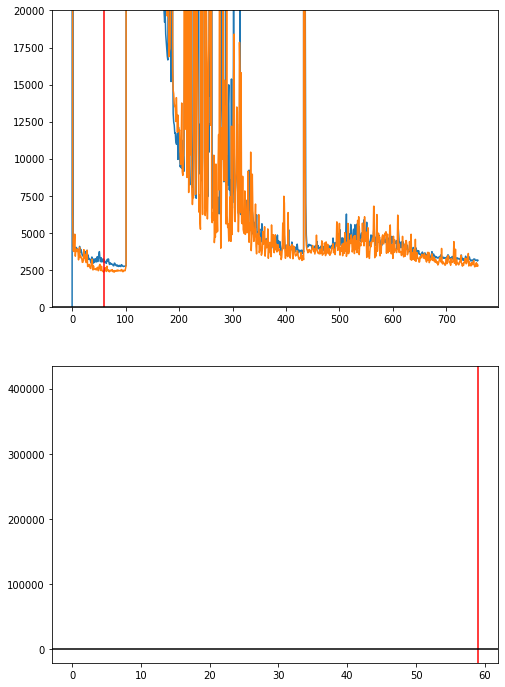

In [37]:
df_history = pd.DataFrame(history)

fig, axes = plt.subplots(2,1,figsize = (8,12))

axes[0].plot(df_history['epoch'], df_history['train_loss'])
axes[0].plot(df_history['epoch'], df_history['test_loss'])
axes[0].axvline(x = check_epoch, ymin = 0, ymax = df_history['test_loss'].max(), color = 'r')
axes[0].axhline(y = default_loss, xmin = 0, xmax = df_history['epoch'].max(), color = 'k')
axes[0].set_ylim(0, 20000)

axes[1].plot(df_history['epoch'], df_history['train_meas'])
axes[1].plot(df_history['epoch'], df_history['test_meas'])
axes[1].axvline(x = check_epoch, ymin = 0, ymax = df_history['test_meas'].max(), color = 'r')
axes[1].axhline(y = default_meas, xmin = 0, xmax = df_history['epoch'].max(), color = 'k')

In [ ]:
del X_train, X_test, y_train, y_test

# Submission

In [38]:
df_test = pd.read_pickle(str(data_dir / "gsdc_test.pkl.gzip"))

print(df_test.shape)
df_test.head()

(91486, 102)


,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,utcTimeMillis_x,elapsedRealtimeNanos_x,UncalGyroXRadPerSec,...,xSatVelMps,ySatVelMps,zSatVelMps,satClkBiasM,satClkDriftMps,rawPrM,rawPrUncM,isrbM,ionoDelayM,tropoDelayM
0,2020-05-15-US-MTV-1,Pixel4XL,1273608752446,37.416623,-122.082055,-24.21,2020-05-15-US-MTV-1_Pixel4XL,1.589574e+12,8.826378e+12,-0.005630,...,292.938,-62.944,3162.107,-136834.317,-0.002,2.177887e+07,4.197,0.000,4.810,3.462
1,2020-05-15-US-MTV-1,Pixel4XL,1273608753446,37.416590,-122.082073,-29.97,2020-05-15-US-MTV-1_Pixel4XL,1.589574e+12,8.827378e+12,-0.009253,...,1255.685,1388.784,2026.329,167809.434,-0.002,2.333124e+07,0.899,-2345.215,6.541,2.641
2,2020-05-15-US-MTV-1,Pixel4XL,1273608754446,37.416593,-122.082084,-29.85,2020-05-15-US-MTV-1_Pixel4XL,1.589574e+12,8.828377e+12,-0.000794,...,1255.940,1388.826,2026.043,167809.433,-0.002,2.333131e+07,0.600,-2344.516,6.541,2.647
3,2020-05-15-US-MTV-1,Pixel4XL,1273608755446,37.416580,-122.082067,-28.53,2020-05-15-US-MTV-1_Pixel4XL,1.589574e+12,8.829377e+12,0.036793,...,2808.676,317.171,370.156,-47469.410,0.001,2.082429e+07,3.298,0.000,4.010,3.005
4,2020-05-15-US-MTV-1,Pixel4XL,1273608756446,37.416594,-122.082065,-27.70,2020-05-15-US-MTV-1_Pixel4XL,1.589574e+12,8.830376e+12,-0.030948,...,813.076,1060.450,2833.855,-81574.962,-0.002,2.087243e+07,2.099,0.000,3.948,2.855


In [39]:
model.load_state_dict(torch.load(checkpoint_path))
torch.save(model.state_dict(), model_path)

In [40]:
# Load submission sample
submission = pd.read_csv(str(data_dir / "sample_submission.csv"))
print(submission.shape)

(91486, 4)


In [41]:
model = SimpleNetwork(X.shape[1] * X.shape[2], y.shape[1])
model = model.to(device)
model.load_state_dict(torch.load(model_path))

NameError: name 'SimpleNetwork' is not defined

In [ ]:
X, _ = extract_features(df_test, train = False)

X = torch.Tensor(X)

loader_test = DataLoader(X, batch_size = batch_size, shuffle = False)

In [ ]:
model.eval()  # 신경망을 추론 모드로 전환

# 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
predict = []
with torch.no_grad():  # 추론 과정에는 미분이 필요없음
    for data in loader_test:
        data = data.to(device)

        outputs = model(data)  # 데이터를 입력하고 출력을 계산
        predict.append(outputs)
predict = torch.cat(predict, axis = 0).to('cpu')

In [ ]:
predict.shape

In [ ]:
print(submission.shape)
submission.columns

In [ ]:
submission['latDeg'] = predict[:,1]
submission['lngDeg'] = predict[:,2]

In [ ]:
submission.to_csv(f"./models/{notebookName}/{num_files} - result.csv", index = False)
pd.DataFrame([]).to_csv(dummy_path)